## Dahlin controller

We will replicate the controller output in figure 17.11a. This notebook has a [video commentary](https://youtu.be/7c-f-6pMgt4).

*Note* I am replicating these results using analytic methods to show that the artefacts are not numerical but rather fundamental to the calculations. If you simply want to simulate the action of a discrete controller on a continuous system, have a look at the [Simple discrete controller simulation](Simple%20discrete%20controller%20simulation) notebook.

In [1]:
import sympy
sympy.init_printing()
import tbcontrol
tbcontrol.expectversion('0.1.3')

Discretise the system
--------------------------------

We need to find the corresponding z transform of the hold element and the system. Since $H=1/s(1 - e^{-Ts})$, we can find $F=G/s$, from there $f(t)$ and then work out the $z$ transform

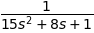

In [2]:
s, t = sympy.symbols('s, t')
Gs = 1/(15*s**2 + 8*s + 1)
Gs

In [3]:
f = sympy.inverse_laplace_transform(Gs/s, s, t).simplify()
sympy.nsimplify(sympy.N(f)).simplify()

We can see that $f(t)$ is the sum of 1 and two exponentials. It is easy to determine the corresponding z transforms from the table

| Time domain | Laplace-transform | z-transform ($b=e^{-aT}$) |
|-------------|-------------------|---------------------------|
|$e^{-at}$    | $\frac{1}{s+a}$   | $\frac{1}{1-bz^{-1}}$     |


In [4]:
z, q = sympy.symbols('z, q')

Now the sampling interval

In [5]:
T = 1 # Sampling interval

In [5]:
def expz(a):
    b = sympy.exp(-a*T)
    return 1/(1 - b*z**-1)

In [6]:
Fz = -5/2*expz(1/5)  + 3/2*expz(1/3) + 1/(1 - z**-1)

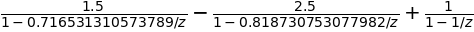

In [7]:
Fz

Let's see if we did that right

In [8]:
import tbcontrol.symbolic

In [9]:
def plotdiscrete(fz, N):
    values = tbcontrol.symbolic.sampledvalues(fz, z, N)
    times = [n*T for n in range(N)]
    plt.stem(times, values)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import numpy

In [12]:
ts = numpy.linspace(0, 10, 300)

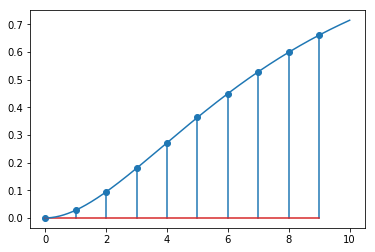

In [13]:
plotdiscrete(Fz, 10)
plt.plot(ts, tbcontrol.symbolic.evaluate_at_times(f, t, ts))

Here is the transform of the system and the hold element. See the [Discrete control](Discrete%20control.ipynb) notebook for the derivation.

In [14]:
HG_z = Fz*(1 - z**-1)

Dahlin Controller
-----------------

The desired closed loop response is first order

In [15]:
θ = 0 # system dead time 
λ = 1 # Dahlin's lambda
h = θ # Dahlin's h

First order response in eq 17-63

In [16]:
N = θ/T
A = sympy.exp(-T/λ)
yclz = (1 - A)*z**(-N-1)/(1 - A*z**-1)

In [17]:
K = (1/HG_z*yclz/(1 - yclz)).simplify()

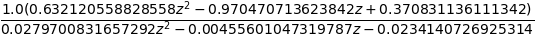

In [18]:
K

In [19]:
#K = 0.632/(1 - z*-1) * (1 - 1.5353*z**-1 + 0.5866*z**-2)/(0.028 + 0.0234*z**-1)

We will model the control response to a unit step in reference signal

In [20]:
rz = 1/(1 - z**-1) # unit step in z

Now we can calculate the z-domain version of the controller output

In [21]:
uz = K/(1 + K*HG_z)*rz

In [22]:
N = 10

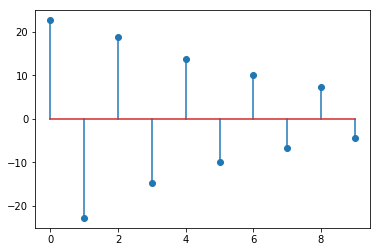

In [23]:
plotdiscrete(uz, N)

This oscillating controller output is known as "ringing". It is an undesirable effect.

Continuous response
-------------------

By design the controlled variable follows an exponential at the sampling points.

In [24]:
yz = K*HG_z/(1 + K*HG_z)*rz

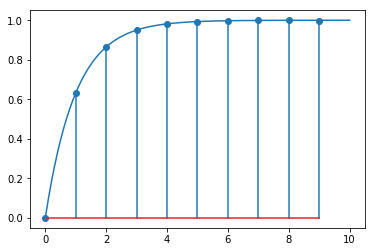

In [25]:
plotdiscrete(yz, N)
plt.plot(ts, 1 - numpy.exp(-ts/λ))

But what does it really look like between data points? First, let's construct the response of the system to a single sampling time length pulse input

In [26]:
p = f - f.subs(t, t-T)

Note that there is a slight issue with finding the value of this function at zero, so we avoid that point in plotting by starting at some small value which is not zero.

In [27]:
smallvalue = 0.001

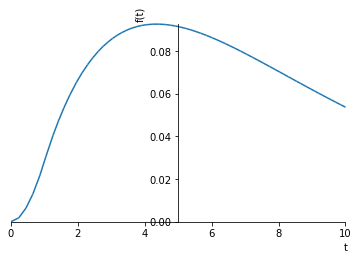

In [28]:
sympy.plot(p, (t, smallvalue, 10))

Let's get the values of the controller output as a list:

In [29]:
u = tbcontrol.symbolic.sampledvalues(uz, z, N)

Now, we calculate the output of the system as the sum of the various pulse inputs.

In [30]:
yt = numpy.zeros_like(ts)
for i in range(0, N):
    yt += [float(sympy.N(u[i]*p.subs(t, ti-i + smallvalue))) for ti in ts]

Finally, we present the discrete system response, the designed response and the analytical continuous response on the same graph.

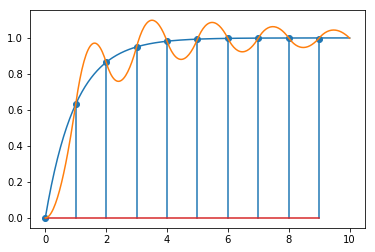

In [31]:
plotdiscrete(yz, 10)
plt.plot(ts, 1 - numpy.exp(-ts/λ))
plt.plot(ts, yt)